In [1]:
!pip install recommenders surprise cornac==2.3.0 optuna==4.2.1 optuna-dashboard nbformat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.3 MB/

In [2]:
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install --only-upgrade libstdc++6

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint C8EC952E2A0E1FBDC5090F6A2C277A0A352154E5
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,604 kB]
Hit:4 http://archi

In [3]:
!cp '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/utils.py' .

In [4]:
import pandas as pd
import sys
import cornac
import recommenders
import optuna
import surprise

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import (
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
)
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.utils.notebook_utils import store_metadata
from recommenders.models.cornac.cornac_utils import predict_ranking

from surprise import Dataset, NormalPredictor, Reader
from utils import compute_ranking_predictions

In [5]:
DATA_PATH = '/content/drive/MyDrive/Final Project/Codes/animelist-goodbooks-recommendation/ml-1m/data_split/'

In [6]:
train_data = pd.read_csv(f'{DATA_PATH}/data_train.tsv', sep='\t')
valid_data = pd.read_csv(f'{DATA_PATH}/data_valid.tsv', sep='\t')

In [8]:
train_data['time'] = pd.to_datetime(train_data["timestamp"], utc=True)
valid_data['time'] = pd.to_datetime(valid_data["timestamp"], utc=True)

In [9]:
SEED = 100

## Hyperparameter BPR

In [10]:
class ObjectiveBPR(object):
    def __init__(self, train_data, valid_data):
        self.train_data = train_data
        self.valid_data = valid_data
        self.train_set = cornac.data.Dataset.from_uir(self.train_data[['user_id', 'movie_id', 'rating']].itertuples(index=False), seed=SEED)

    def __call__(self, trial):

        factors = trial.suggest_int("factors", 20, 200, step=20)
        lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)
        lambda_reg = trial.suggest_float("lambda_reg", 1e-3, 1e-1, log=True)
        bpr = cornac.models.BPR(
            k=factors,
            max_iter=20,
            learning_rate=lr,
            lambda_reg=lambda_reg,
            verbose=True,
            seed=SEED
        )
        bpr.fit(self.train_set)
        all_predictions = predict_ranking(bpr, self.train_data, usercol='user_id', itemcol='movie_id', remove_seen=True)
        ndcg_score = ndcg_at_k(self.valid_data, all_predictions, col_user="user_id", col_item="movie_id", col_rating='rating', k=10)

        return ndcg_score

In [11]:
objective = ObjectiveBPR(train_data, valid_data)
study_name = "movielens-bpr"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-04-19 10:14:27,606] A new study created in RDB with name: movielens-bpr


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!
Optimization finished!


[I 2025-04-19 10:18:03,954] Trial 6 finished with value: 0.09924734484452888 and parameters: {'factors': 140, 'lr': 0.04756196084268145, 'lambda_reg': 0.0012294441961473747}. Best is trial 6 with value: 0.09924734484452888.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:18:04,562] Trial 0 finished with value: 0.08919497101592372 and parameters: {'factors': 20, 'lr': 0.002589025892588867, 'lambda_reg': 0.00597805749889526}. Best is trial 6 with value: 0.09924734484452888.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:18:14,036] Trial 2 finished with value: 0.08905055364619266 and parameters: {'factors': 140, 'lr': 0.0010413979739169804, 'lambda_reg': 0.006621919882391778}. Best is trial 6 with value: 0.09924734484452888.


Optimization finished!


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:18:14,721] Trial 1 finished with value: 0.08949148625247187 and parameters: {'factors': 140, 'lr': 0.0020492868493631215, 'lambda_reg': 0.0013669276427762016}. Best is trial 6 with value: 0.09924734484452888.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-19 10:18:41,051] Trial 4 finished with value: 0.08879104313823505 and parameters: {'factors': 200, 'lr': 0.002164984314410264, 'lambda_reg': 0.0014630442826449462}. Best is trial 6 with value: 0.09924734484452888.
[I 2025-04-19 10:18:41,059] Trial 5 finished with value: 0.09442499135829827 and parameters: {'factors': 140, 'lr': 0.01586330859564287, 'lambda_reg': 0.0014059505267229155}. Best is trial 6 with value: 0.09924734484452888.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:18:57,971] Trial 7 finished with value: 0.09975687057057993 and parameters: {'factors': 180, 'lr': 0.05710132783262272, 'lambda_reg': 0.0028435677191096455}. Best is trial 7 with value: 0.09975687057057993.


Optimization finished!


[I 2025-04-19 10:19:08,006] Trial 3 finished with value: 0.09108405876940272 and parameters: {'factors': 180, 'lr': 0.04642351351931083, 'lambda_reg': 0.06476376084644711}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!
Optimization finished!


[I 2025-04-19 10:20:25,110] Trial 8 finished with value: 0.08882683213105792 and parameters: {'factors': 60, 'lr': 0.013913106970122326, 'lambda_reg': 0.03389754729505004}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:20:48,587] Trial 9 finished with value: 0.08869839081713143 and parameters: {'factors': 100, 'lr': 0.0011104381609931665, 'lambda_reg': 0.0074917662340837484}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:21:27,150] Trial 10 finished with value: 0.0996781661185248 and parameters: {'factors': 120, 'lr': 0.029182516874911763, 'lambda_reg': 0.0198862607599596}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-19 10:22:06,002] Trial 12 finished with value: 0.08894521840679923 and parameters: {'factors': 40, 'lr': 0.0018862381488045914, 'lambda_reg': 0.00460810611609438}. Best is trial 7 with value: 0.09975687057057993.
[I 2025-04-19 10:22:06,037] Trial 11 finished with value: 0.09937149514920594 and parameters: {'factors': 120, 'lr': 0.04294396503691802, 'lambda_reg': 0.003712205690890024}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-19 10:22:49,743] Trial 13 finished with value: 0.09895797206955254 and parameters: {'factors': 160, 'lr': 0.048150211364844965, 'lambda_reg': 0.03743134602888299}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:23:14,443] Trial 15 finished with value: 0.08916548668964351 and parameters: {'factors': 100, 'lr': 0.0013681566822060216, 'lambda_reg': 0.01720550269914393}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:23:29,107] Trial 14 finished with value: 0.08921229276478614 and parameters: {'factors': 20, 'lr': 0.003719806905621388, 'lambda_reg': 0.006842578267185747}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:23:40,883] Trial 16 finished with value: 0.08837173429521292 and parameters: {'factors': 160, 'lr': 0.005809764382065478, 'lambda_reg': 0.004384078663303672}. Best is trial 7 with value: 0.09975687057057993.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:23:58,164] Trial 17 finished with value: 0.1043018639861254 and parameters: {'factors': 200, 'lr': 0.08694665612516418, 'lambda_reg': 0.02081111814421324}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!
Optimization finished!


[I 2025-04-19 10:24:35,963] Trial 18 finished with value: 0.1002071239164489 and parameters: {'factors': 80, 'lr': 0.08269346906223386, 'lambda_reg': 0.01607083154424049}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:25:13,820] Trial 20 finished with value: 0.10076908990037141 and parameters: {'factors': 180, 'lr': 0.09995040826678121, 'lambda_reg': 0.021230344787976314}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:25:13,956] Trial 19 finished with value: 0.10128469881614266 and parameters: {'factors': 180, 'lr': 0.08848648888597781, 'lambda_reg': 0.016399027796015382}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:25:36,864] Trial 21 finished with value: 0.10001890926688049 and parameters: {'factors': 80, 'lr': 0.09901291111624502, 'lambda_reg': 0.016682536763616706}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!
Optimization finished!


[I 2025-04-19 10:26:53,071] Trial 22 finished with value: 0.10349608398382193 and parameters: {'factors': 200, 'lr': 0.08925112950308835, 'lambda_reg': 0.015926682315965123}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:27:56,929] Trial 23 finished with value: 0.10236669224146647 and parameters: {'factors': 200, 'lr': 0.09717236900888457, 'lambda_reg': 0.01452108604566489}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:27:57,522] Trial 24 finished with value: 0.1005780856358094 and parameters: {'factors': 80, 'lr': 0.0836652084628725, 'lambda_reg': 0.01805695776002553}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-19 10:29:00,085] Trial 26 finished with value: 0.09931314165749547 and parameters: {'factors': 80, 'lr': 0.09053398841989724, 'lambda_reg': 0.013569436401158689}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:29:00,846] Trial 25 finished with value: 0.09776280519927685 and parameters: {'factors': 200, 'lr': 0.09464181202159108, 'lambda_reg': 0.0026975752942832807}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:29:31,060] Trial 27 finished with value: 0.10253290875052924 and parameters: {'factors': 200, 'lr': 0.08952916938021956, 'lambda_reg': 0.0119178004453556}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:29:34,411] Trial 28 finished with value: 0.10305571756394155 and parameters: {'factors': 200, 'lr': 0.09658895344528003, 'lambda_reg': 0.0324290680038635}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!
Optimization finished!


[I 2025-04-19 10:30:06,661] Trial 29 finished with value: 0.09631492377400852 and parameters: {'factors': 200, 'lr': 0.026045745342326357, 'lambda_reg': 0.03554136823969064}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-19 10:31:00,472] Trial 30 finished with value: 0.10251004005492795 and parameters: {'factors': 200, 'lr': 0.027416640956123384, 'lambda_reg': 0.011487375881920099}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:31:19,537] Trial 31 finished with value: 0.10176157869797922 and parameters: {'factors': 200, 'lr': 0.024077310989698047, 'lambda_reg': 0.010502044243115898}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:31:57,346] Trial 32 finished with value: 0.10234411795923577 and parameters: {'factors': 200, 'lr': 0.026850017708756422, 'lambda_reg': 0.009565019890601092}. Best is trial 17 with value: 0.1043018639861254.


Optimization finished!


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:33:07,374] Trial 34 finished with value: 0.10232857209240648 and parameters: {'factors': 200, 'lr': 0.026973984861878523, 'lambda_reg': 0.010661350199216952}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:33:07,396] Trial 33 finished with value: 0.0963208478378373 and parameters: {'factors': 200, 'lr': 0.025705517653617862, 'lambda_reg': 0.03457170427573704}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:33:37,632] Trial 35 finished with value: 0.10283677686856624 and parameters: {'factors': 200, 'lr': 0.029070185353109, 'lambda_reg': 0.010526359283992823}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:33:37,750] Trial 36 finished with value: 0.09345869019402965 and parameters: {'factors': 160, 'lr': 0.023464867215289884, 'lambda_reg': 0.029559397025465502}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!
Optimization finished!


[I 2025-04-19 10:34:22,848] Trial 38 finished with value: 0.10047690651979777 and parameters: {'factors': 160, 'lr': 0.06616624421916763, 'lambda_reg': 0.02565058528062953}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:34:23,140] Trial 37 finished with value: 0.09167470644348398 and parameters: {'factors': 160, 'lr': 0.029371951655925207, 'lambda_reg': 0.053907749436615096}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!
Optimization finished!


[I 2025-04-19 10:35:13,418] Trial 39 finished with value: 0.10045132402713801 and parameters: {'factors': 160, 'lr': 0.06264973652812128, 'lambda_reg': 0.027997917598766756}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


[I 2025-04-19 10:36:08,119] Trial 40 finished with value: 0.10060115712231167 and parameters: {'factors': 160, 'lr': 0.062464088334201626, 'lambda_reg': 0.024333018120206985}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:36:27,418] Trial 41 finished with value: 0.0929916409212682 and parameters: {'factors': 160, 'lr': 0.06325857693672757, 'lambda_reg': 0.074463520514212}. Best is trial 17 with value: 0.1043018639861254.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-19 10:36:27,781] Trial 42 finished with value: 0.09288623338818904 and parameters: {'factors': 160, 'lr': 0.06184227146160967, 'lambda_reg': 0.07496758064368969}. Best is trial 17 with value: 0.1043018639861254.


Optimization finished!
Optimization finished!


[I 2025-04-19 10:37:16,299] Trial 43 finished with value: 0.09372445272993438 and parameters: {'factors': 180, 'lr': 0.0593699227429647, 'lambda_reg': 0.06280674298639148}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:37:31,142] Trial 44 finished with value: 0.09353165273337355 and parameters: {'factors': 180, 'lr': 0.06524665144265185, 'lambda_reg': 0.06524447644209191}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:38:00,018] Trial 46 finished with value: 0.09764152554251807 and parameters: {'factors': 180, 'lr': 0.06283602986754418, 'lambda_reg': 0.049487880075893054}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:38:00,079] Trial 45 finished with value: 0.09647961156553761 and parameters: {'factors': 180, 'lr': 0.0621339092692828, 'lambda_reg': 0.05446977074267927}. Best is trial 17 with value: 0.1043018639861254.
[I 2025-04-19 10:38:29,249] Trial 47 finished with value: 0.08427190411666449 and parameters: {'factors': 180

In [12]:
print(study.best_trial)

FrozenTrial(number=17, state=1, values=[0.1043018639861254], datetime_start=datetime.datetime(2025, 4, 19, 10, 20, 53, 696658), datetime_complete=datetime.datetime(2025, 4, 19, 10, 23, 58, 133976), params={'factors': 200, 'lr': 0.08694665612516418, 'lambda_reg': 0.02081111814421324}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'lambda_reg': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=18, value=None)


In [13]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

Best params:  {'factors': 200, 'lr': 0.08694665612516418, 'lambda_reg': 0.02081111814421324}
Best value:  0.1043018639861254
Best Trial:  FrozenTrial(number=17, state=1, values=[0.1043018639861254], datetime_start=datetime.datetime(2025, 4, 19, 10, 20, 53, 696658), datetime_complete=datetime.datetime(2025, 4, 19, 10, 23, 58, 133976), params={'factors': 200, 'lr': 0.08694665612516418, 'lambda_reg': 0.02081111814421324}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'lambda_reg': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=18, value=None)
Trials:  [FrozenTrial(number=0, state=1, values=[0.08919497101592372], datetime_start=datetime.datetime(2025, 4, 19, 10, 14, 27, 630674), datetime_complete=datetime.datetime(2025, 4, 19, 10, 18, 4, 537565), params={'factors': 20, 'lr': 0.002589025892588867, 'lambda_reg': 

### Visualization

In [14]:
optuna.visualization.plot_optimization_history(study)

In [16]:
optuna.visualization.plot_parallel_coordinate(study)

In [17]:
optuna.visualization.plot_contour(study)

In [18]:
optuna.visualization.plot_slice(study)

In [19]:
optuna.visualization.plot_slice(study, params=["factors"])

In [20]:
optuna.visualization.plot_slice(study, params=["lambda_reg"])

In [21]:
optuna.visualization.plot_slice(study, params=["lr"])

In [22]:
optuna.visualization.plot_param_importances(study)

In [23]:
optuna.visualization.plot_edf(study)

In [24]:
optuna.visualization.plot_rank(study)

In [25]:
optuna.visualization.plot_timeline(study)

In [26]:
optuna.visualization.plot_intermediate_values(study)

[W 2025-04-19 10:51:44,885] You need to set up the pruning feature to utilize `plot_intermediate_values()`


## Hyperparameter SVD

In [27]:
class ObjectiveSVD(object):
    def __init__(self, train_data, valid_data):
      # A reader is still needed but only the rating_scale param is required.
      self.reader = Reader(rating_scale=(1, 10))
      self.train_data = train_data
      self.valid_data = valid_data
      self.train_set = Dataset.load_from_df(train_data[["user_id", "movie_id", "rating"]], self.reader).build_full_trainset()

    def __call__(self, trial):

      n_factors = trial.suggest_int("n_factors", 20, 200, step=20)
      lr_all = trial.suggest_float("lr_all", 1e-3, 1e-1, log=True)
      reg_all = trial.suggest_float("reg_all", 1e-3, 1e-1, log=True)

      svd = surprise.SVD(random_state=SEED,
                         n_epochs=20,
                         verbose=False,
                         n_factors=n_factors,
                         lr_all = lr_all,
                         reg_all = reg_all
                         )
      svd.fit(self.train_set)

      all_predictions_svd = compute_ranking_predictions(
        svd, self.train_data, usercol="user_id", itemcol="movie_id", predcol="prediction", remove_seen=True
      )

      ndcg_score = ndcg_at_k(self.valid_data, all_predictions_svd, col_user="user_id", col_item="movie_id", col_rating='rating', k=10)

      return ndcg_score

In [28]:
objective = ObjectiveSVD(train_data, valid_data)
study_name = "movielens-svd"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study_svd = optuna.create_study(direction="maximize", study_name=study_name, storage=storage_name)
study_svd.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-04-19 10:52:04,825] A new study created in RDB with name: movielens-svd


  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:07:30,018] Trial 2 finished with value: 0.050214918583274336 and parameters: {'n_factors': 20, 'lr_all': 0.007358162288256377, 'reg_all': 0.0015901316084149036}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:08:07,109] Trial 6 finished with value: 0.030445579118658823 and parameters: {'n_factors': 40, 'lr_all': 0.002041002961739756, 'reg_all': 0.054421819279674884}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:12:03,093] Trial 0 finished with value: 0.032653995358478384 and parameters: {'n_factors': 80, 'lr_all': 0.0015372207454765242, 'reg_all': 0.009139895230396685}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:13:25,384] Trial 1 finished with value: 0.04839815015534649 and parameters: {'n_factors': 100, 'lr_all': 0.006925710826781963, 'reg_all': 0.0021578079964130904}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:14:22,769] Trial 7 finished with value: 0.03539289844880256 and parameters: {'n_factors': 120, 'lr_all': 0.013516425532444412, 'reg_all': 0.013309191548953592}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:17:14,744] Trial 4 finished with value: 0.02574209680528058 and parameters: {'n_factors': 120, 'lr_all': 0.08019287430697719, 'reg_all': 0.00244642917664678}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:21:38,301] Trial 5 finished with value: 0.02879671960858996 and parameters: {'n_factors': 140, 'lr_all': 0.03422288751623624, 'reg_all': 0.008714179556113396}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 12:22:23,301] Trial 3 finished with value: 0.042035480311162186 and parameters: {'n_factors': 200, 'lr_all': 0.006461434072816409, 'reg_all': 0.0035470502934694496}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:37:53,126] Trial 11 finished with value: 0.03626841311911118 and parameters: {'n_factors': 60, 'lr_all': 0.019889349475450357, 'reg_all': 0.0013536365725525638}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:38:06,908] Trial 8 finished with value: 0.03422349888855396 and parameters: {'n_factors': 80, 'lr_all': 0.001556573822903621, 'reg_all': 0.002326181801320318}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:42:42,243] Trial 9 finished with value: 0.02539057991728802 and parameters: {'n_factors': 160, 'lr_all': 0.05510043446393141, 'reg_all': 0.03085951639318375}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:44:10,854] Trial 12 finished with value: 0.04258750114069566 and parameters: {'n_factors': 20, 'lr_all': 0.014893443273882073, 'reg_all': 0.007647529066560645}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:45:18,815] Trial 10 finished with value: 0.0308218665298198 and parameters: {'n_factors': 100, 'lr_all': 0.0013272986942319662, 'reg_all': 0.019177219382034916}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:49:43,787] Trial 15 finished with value: 0.02086871102400714 and parameters: {'n_factors': 60, 'lr_all': 0.05075887947741401, 'reg_all': 0.005527031511882244}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:50:48,837] Trial 13 finished with value: 0.0007236019458151832 and parameters: {'n_factors': 120, 'lr_all': 0.06511755615887593, 'reg_all': 0.08952508492492237}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 13:56:20,765] Trial 14 finished with value: 0.04413956195255581 and parameters: {'n_factors': 180, 'lr_all': 0.0075393656232642095, 'reg_all': 0.002357922675730114}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:01:12,963] Trial 17 finished with value: 0.027399004215133742 and parameters: {'n_factors': 20, 'lr_all': 0.004395619439034649, 'reg_all': 0.08754393542779622}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:02:12,632] Trial 16 finished with value: 0.042830913047957865 and parameters: {'n_factors': 20, 'lr_all': 0.01616468238255772, 'reg_all': 0.0033458700636003133}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:06:16,873] Trial 18 finished with value: 0.043031026955920974 and parameters: {'n_factors': 20, 'lr_all': 0.00491638047584881, 'reg_all': 0.0010120400988676468}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:08:13,428] Trial 19 finished with value: 0.04257942714262222 and parameters: {'n_factors': 20, 'lr_all': 0.004847460224462828, 'reg_all': 0.001011403770111634}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:09:09,601] Trial 20 finished with value: 0.03701876384432499 and parameters: {'n_factors': 20, 'lr_all': 0.004446716679299308, 'reg_all': 0.0041187098551364555}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:12:45,685] Trial 22 finished with value: 0.04767524845294368 and parameters: {'n_factors': 20, 'lr_all': 0.006018846071397371, 'reg_all': 0.0011702629502708395}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:12:59,073] Trial 21 finished with value: 0.04600358601935774 and parameters: {'n_factors': 20, 'lr_all': 0.005432143984129146, 'reg_all': 0.001132791294396301}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 15:17:15,918] Trial 23 finished with value: 0.03558515673846314 and parameters: {'n_factors': 20, 'lr_all': 0.0036812298053562056, 'reg_all': 0.0010701932853529152}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:00:49,330] Trial 25 finished with value: 0.046307735796450325 and parameters: {'n_factors': 60, 'lr_all': 0.004618735263765614, 'reg_all': 0.0010099648627144397}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:01:32,024] Trial 24 finished with value: 0.04052944270933715 and parameters: {'n_factors': 40, 'lr_all': 0.004446639802777829, 'reg_all': 0.0013388234983515415}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:05:17,322] Trial 26 finished with value: 0.03644707476199363 and parameters: {'n_factors': 60, 'lr_all': 0.0031005919341712037, 'reg_all': 0.0014787114620458848}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:06:08,224] Trial 27 finished with value: 0.03621599331118237 and parameters: {'n_factors': 60, 'lr_all': 0.0030824919724332495, 'reg_all': 0.0015737784228174964}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:10:41,658] Trial 30 finished with value: 0.03562286639921356 and parameters: {'n_factors': 60, 'lr_all': 0.0029526827971744184, 'reg_all': 0.0016189617845822665}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:11:09,194] Trial 29 finished with value: 0.034844741479620966 and parameters: {'n_factors': 60, 'lr_all': 0.0026991333208268974, 'reg_all': 0.0016155469048310274}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:14:35,709] Trial 28 finished with value: 0.04302513176702992 and parameters: {'n_factors': 200, 'lr_all': 0.007273767290043203, 'reg_all': 0.0021219452640544247}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:15:32,675] Trial 31 finished with value: 0.03450215468591416 and parameters: {'n_factors': 60, 'lr_all': 0.0026091488959377263, 'reg_all': 0.001862696314756377}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:52:58,537] Trial 32 finished with value: 0.049417085624268185 and parameters: {'n_factors': 40, 'lr_all': 0.008779982806125365, 'reg_all': 0.0017250947954651587}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:56:09,683] Trial 33 finished with value: 0.03675429528597561 and parameters: {'n_factors': 80, 'lr_all': 0.002754161312652626, 'reg_all': 0.0017907204485266355}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 16:59:38,821] Trial 34 finished with value: 0.046489619328030404 and parameters: {'n_factors': 80, 'lr_all': 0.009216959148624878, 'reg_all': 0.0018404325967082264}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:00:11,853] Trial 35 finished with value: 0.049219629951159034 and parameters: {'n_factors': 40, 'lr_all': 0.008574821154650848, 'reg_all': 0.0019537169281856424}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:06:57,035] Trial 39 finished with value: 0.04704957489368144 and parameters: {'n_factors': 40, 'lr_all': 0.010377607627907594, 'reg_all': 0.003183281074535283}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:08:33,245] Trial 36 finished with value: 0.04364683215517986 and parameters: {'n_factors': 100, 'lr_all': 0.010169535800079349, 'reg_all': 0.0019381676770102278}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:10:26,650] Trial 38 finished with value: 0.04433006185001847 and parameters: {'n_factors': 80, 'lr_all': 0.010062803576307736, 'reg_all': 0.002883042597141136}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:11:02,744] Trial 37 finished with value: 0.04305747874098045 and parameters: {'n_factors': 100, 'lr_all': 0.010419917510847344, 'reg_all': 0.0020666949995715813}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:46:16,557] Trial 40 finished with value: 0.048068832348047916 and parameters: {'n_factors': 40, 'lr_all': 0.009567489068449215, 'reg_all': 0.003072480821409923}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:52:19,730] Trial 41 finished with value: 0.04765435951380902 and parameters: {'n_factors': 40, 'lr_all': 0.009913347426700943, 'reg_all': 0.0030165998948885626}. Best is trial 2 with value: 0.050214918583274336.


  0%|          | 0/5755 [00:00<?, ?it/s]

[I 2025-04-19 17:54:12,295] Trial 42 finished with value: 0.03172625725015023 and parameters: {'n_factors': 40, 'lr_all': 0.023233925486840938, 'reg_all': 0.0031485321050579544}. Best is trial 2 with value: 0.050214918583274336.
[I 2025-04-19 17:54:58,586] Trial 43 finished with value: 0.04738053995955944 and parameters: {'n_factors': 40, 'lr_all': 0.010114937513358468, 'reg_all': 0.0031644699661069397}. Best is trial 2 with value: 0.050214918583274336.
[I 2025-04-19 17:58:31,671] Trial 44 finished with value: 0.031538871518847184 and parameters: {'n_factors': 40, 'lr_all': 0.02293000091060574, 'reg_all': 0.0050665400826383055}. Best is trial 2 with value: 0.050214918583274336.
[I 2025-04-19 18:00:39,046] Trial 45 finished with value: 0.029105940618558694 and parameters: {'n_factors': 40, 'lr_all': 0.025725520215350246, 'reg_all': 0.004715729551688383}. Best is trial 2 with value: 0.050214918583274336.
[I 2025-04-19 18:04:49,191] Trial 47 finished with value: 0.031248562749263197 and p

In [29]:
print(study_svd.best_trial)

FrozenTrial(number=2, state=1, values=[0.050214918583274336], datetime_start=datetime.datetime(2025, 4, 19, 10, 52, 4, 922564), datetime_complete=datetime.datetime(2025, 4, 19, 12, 7, 29, 776721), params={'n_factors': 20, 'lr_all': 0.007358162288256377, 'reg_all': 0.0015901316084149036}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'reg_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=3, value=None)


In [30]:
print("Best params: ", study_svd.best_params)
print("Best value: ", study_svd.best_value)
print("Best Trial: ", study_svd.best_trial)
print("Trials: ", study_svd.trials)

Best params:  {'n_factors': 20, 'lr_all': 0.007358162288256377, 'reg_all': 0.0015901316084149036}
Best value:  0.050214918583274336
Best Trial:  FrozenTrial(number=2, state=1, values=[0.050214918583274336], datetime_start=datetime.datetime(2025, 4, 19, 10, 52, 4, 922564), datetime_complete=datetime.datetime(2025, 4, 19, 12, 7, 29, 776721), params={'n_factors': 20, 'lr_all': 0.007358162288256377, 'reg_all': 0.0015901316084149036}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_factors': IntDistribution(high=200, log=False, low=20, step=20), 'lr_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'reg_all': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}, trial_id=3, value=None)
Trials:  [FrozenTrial(number=0, state=1, values=[0.032653995358478384], datetime_start=datetime.datetime(2025, 4, 19, 10, 52, 4, 852390), datetime_complete=datetime.datetime(2025, 4, 19, 12, 12, 2, 966455), params={'n_factors': 80, 'lr_all': 0.001537220745476

### Visualization

In [31]:
optuna.visualization.plot_optimization_history(study_svd)

In [32]:
optuna.visualization.plot_parallel_coordinate(study_svd)

In [33]:
optuna.visualization.plot_contour(study_svd)

In [34]:
optuna.visualization.plot_slice(study_svd)

In [35]:
optuna.visualization.plot_slice(study_svd, params=["n_factors"])

In [36]:
optuna.visualization.plot_slice(study_svd, params=["lr_all"])

In [37]:
optuna.visualization.plot_slice(study_svd, params=["reg_all"])

In [38]:
optuna.visualization.plot_param_importances(study_svd)

In [39]:
optuna.visualization.plot_edf(study_svd)

In [40]:
optuna.visualization.plot_rank(study_svd)

In [41]:
optuna.visualization.plot_timeline(study_svd)

## Epoch Parameter BPR

In [42]:
train_data_full = pd.read_csv(f'{DATA_PATH}/data_train_full.tsv', sep='\t')
test_data = pd.read_csv(f'{DATA_PATH}/data_test.tsv', sep='\t')

In [46]:
eval_method = cornac.eval_methods.BaseMethod.from_splits(
  train_data=list(train_data_full[['user_id', 'movie_id', 'rating']].itertuples(index=False)),
  test_data=list(test_data[['user_id', 'movie_id', 'rating']].itertuples(index=False)),
  exclude_unknowns=True,
  verbose=True,
  seed=SEED,
)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 5755
Number of items = 3571
Number of ratings = 665395
Max rating = 5.0
Min rating = 3.0
Global mean = 4.0
---
Test data:
Number of users = 5755
Number of items = 3571
Number of ratings = 166276
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 5755
Total items = 3571


In [47]:
from tqdm.notebook import tqdm
import time

In [50]:
epoch_result_bpr = {}

In [51]:
# Best param: {'factors': 200, 'lr': 0.08694665612516418, 'lambda_reg': 0.02081111814421324}

for epoch in tqdm(range(10,110,10)):

  bpr = cornac.models.BPR(
    k=200,
    max_iter=epoch,
    learning_rate=0.0869,
    lambda_reg=0.0208,
    verbose=True,
    seed=SEED
  )
  start_time = time.time()
  bpr.fit(eval_method.train_set)
  train_time = time.time() - start_time

  start_time = time.time()
  all_predictions = predict_ranking(bpr, train_data_full, usercol='user_id', itemcol='movie_id', remove_seen=True)
  prediction_time = time.time() - start_time

  ndcg_score = ndcg_at_k(test_data, all_predictions, col_user="user_id", col_item="movie_id", col_rating='rating', k=10)
  epoch_result_bpr[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/20 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/40 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/60 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/70 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/80 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/90 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!


In [52]:
epoch_df = pd.DataFrame(epoch_result_bpr).T.reset_index()

In [53]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [54]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.113384,3.244370,27.822768
1,20,0.118213,6.018932,19.365740
2,30,0.121768,8.960648,19.603846
3,40,0.118650,11.681837,19.198025
4,50,0.123862,13.185725,19.361063
5,60,0.123073,16.831861,19.182129
6,70,0.124440,21.049130,19.184386
7,80,0.122615,21.867922,19.190448
8,90,0.119595,26.518957,19.203535
9,100,0.122745,29.154590,19.647153


In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

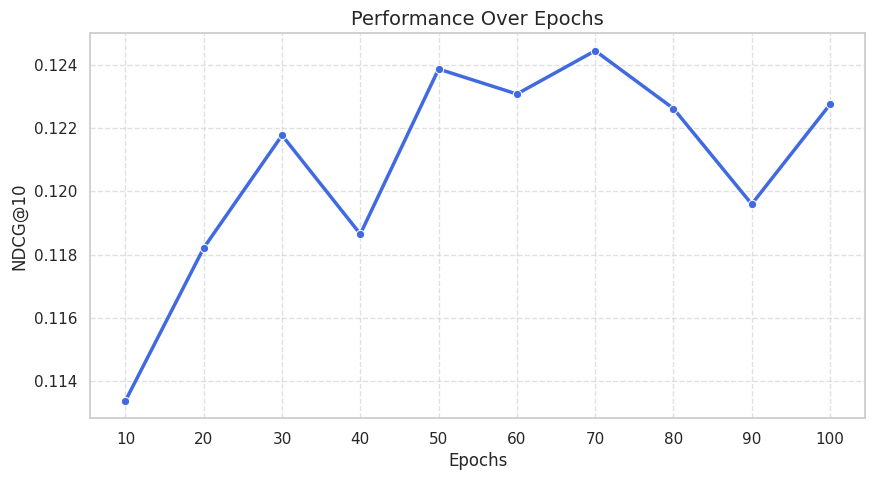

In [56]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

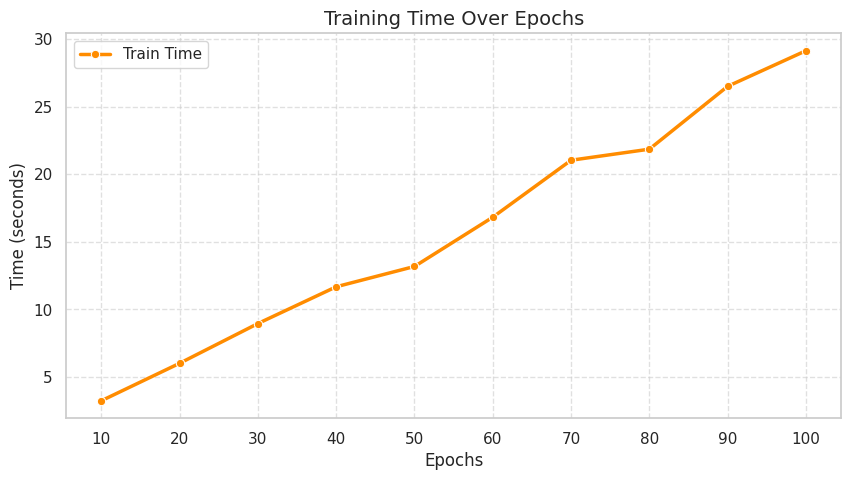

In [57]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Epoch Parameter SVD

In [58]:
epoch_result_svd = {}

In [59]:
reader = Reader(rating_scale=(1, 10))
svd_train_set = Dataset.load_from_df(train_data_full[["user_id", "movie_id", "rating"]], reader).build_full_trainset()

In [60]:
# Best params:  {'n_factors': 20, 'lr_all': 0.007358162288256377, 'reg_all': 0.0015901316084149036}

for epoch in tqdm(range(10,110,10)):

  svd = surprise.SVD(random_state=SEED,
                         n_epochs=epoch,
                         verbose=False,
                         n_factors=20,
                         lr_all=0.0073,
                         reg_all=0.0016
                         )

  start_time = time.time()
  svd.fit(svd_train_set)
  train_time = time.time() - start_time

  start_time = time.time()
  all_predictions_svd = compute_ranking_predictions(
    svd, train_data_full, usercol="user_id", itemcol="movie_id", predcol="prediction", remove_seen=True
  )
  prediction_time = time.time() - start_time

  ndcg_score = ndcg_at_k(test_data, all_predictions_svd, col_user="user_id", col_item="movie_id", col_rating='rating', k=10)
  epoch_result_svd[epoch] = {'ndcg':ndcg_score, 'train_time': train_time, 'prediction_time': prediction_time}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

  0%|          | 0/5755 [00:00<?, ?it/s]

In [61]:
epoch_df = pd.DataFrame(epoch_result_svd).T.reset_index()

In [62]:
epoch_df = epoch_df.rename(columns={"index":"epoch"})

In [63]:
epoch_df

,epoch,ndcg,train_time,prediction_time
0,10,0.042093,1.693415,187.402121
1,20,0.061377,3.133963,151.844970
2,30,0.059788,4.586510,144.754892
3,40,0.054734,6.165618,150.675676
4,50,0.050210,7.640574,147.390071
5,60,0.045724,9.192807,151.478327
6,70,0.041020,10.707512,146.173186
7,80,0.036947,12.339698,145.580280
8,90,0.033843,13.607733,143.514248
9,100,0.031217,15.369605,143.635604


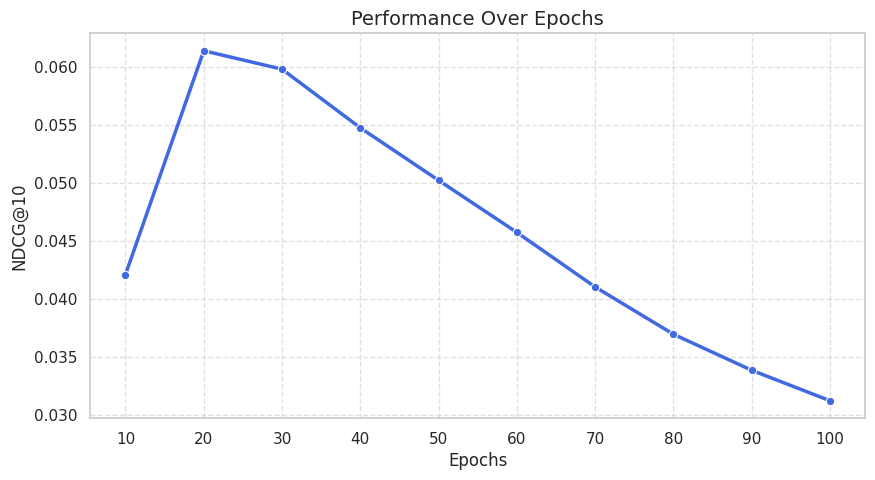

In [64]:
sns.set(style="whitegrid")

# Plot 1: Performance vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="ndcg", marker="o", linewidth=2.5, color="royalblue")
plt.title("Performance Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("NDCG@10", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

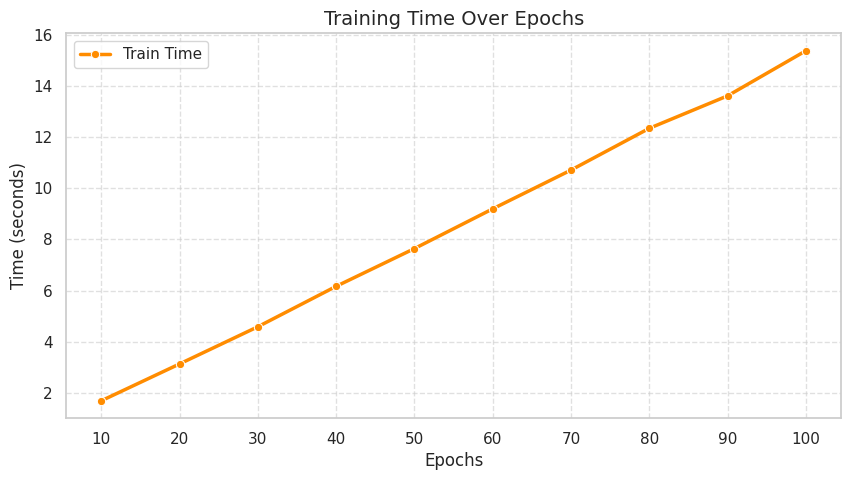

In [65]:
# Plot 2: Train Time & Prediction Time vs. Epochs
plt.figure(figsize=(10, 5))
sns.lineplot(data=epoch_df, x="epoch", y="train_time", marker="o", linewidth=2.5, label="Train Time", color="darkorange")
plt.title("Training Time Over Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xticks(epoch_df["epoch"])
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()